In [1]:
import torch
import pandas as pd
import numpy as np
import os
import torch.utils
import torchvision.transforms
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from PIL import ImageDraw, Image
%matplotlib inline

torch.set_printoptions(threshold=1000)

In [2]:
Dataset_dir = "../Cyclist_Detection/Dataset"

In [3]:
#Writing our Dataset class
class YoloPtDataset(torch.utils.data.Dataset):
    """Dataset with tensor format images and Yolo format labels"""

    def __init__(self,root_dir,data_type=None,transform=None):
        if data_type is None:
            try:
                self.paths = pd.read_csv(os.path.join(root_dir,"src","src.csv"))
                self.paths.values.astype(str)
            except:
                raise TypeError("The directory doesn't have a src file with the paths to all the images")
        elif data_type == 'train' or data_type == 'Train':
            try:
                self.paths = pd.read_csv(os.path.join(root_dir,"src","train_src.csv"))
                self.paths.values.astype(str)
            except:
                raise TypeError("The directory doesn't have a train_src file with the paths to all the images")

        elif data_type == 'val' or data_type == 'Validate' or data_type == 'validate':
            try:
                self.paths = pd.read_csv(os.path.join(root_dir,"src","val_src.csv"))
                self.paths.values.astype(str)
            except:
                raise TypeError("The directory doesn't have a val_src file with the paths to all the images")

        elif data_type == 'test' or data_type == 'Test':
            try:
                self.paths = pd.read_csv(os.path.join(root_dir,"src","test_src.csv"))
                self.paths.values.astype(str)
            except:
                raise TypeError("The directory doesn't have a test_src file with the paths to all the images")
        else:
            raise ValueError("Wrong argument has been passed through data_type, must be one of: train,test,val")



        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path, label_path = self.paths.iloc[idx,1:].values

        return torch.load(img_path),torch.load(label_path)

In [80]:
#Modyifying yolo formatted coordinates to (x_left,y_left,x_right,y_right)
#For handing labeled inputs
def yolo_to_xy(yolo):
    w,h = yolo[3]/2, yolo[4]/2
    return torch.tensor([yolo[0],yolo[1]-w,yolo[2]+h,yolo[1]+w,yolo[2]-h])

#For handling non-labeled inputs
def Yolo_to_xy(yolo):
    w,h = yolo[2]/2,yolo[3]/2
    return torch.tensor([yolo[0]-w,yolo[1]+h,yolo[0]+w,yolo[1]-h])

In [81]:
#Displaying a single image with bounding boxes
def Display_yolo(data,colour='green',width = 5):

    img, label = data[0],data[1]

    #Removing negative padding
    for i in range(len(label)):
        if label[i][0] == -1:
            label = label[0:i]
            break

    resolution = img.size()[1:3]
    trans = torchvision.transforms.ToPILImage()
    img = trans(img)
    draw = ImageDraw.Draw(img)

    #Removing the padded elements in he


    #Re-calculates the yolo format to top-left and bottom right points
    for i in range(len(label)):
        xy = yolo_to_xy(label[i])
        xy[1],xy[3] = xy[1]*resolution[1], xy[3]*resolution[1]
        xy[2],xy[4] = xy[2]*resolution[0],xy[4]*resolution[0]
        xy = xy[1:5].tolist()
        draw.rectangle(xy,outline=colour,width=4)

    display(img)

In [82]:
train = YoloPtDataset(Dataset_dir,data_type='train')
val = YoloPtDataset(Dataset_dir,data_type='val')
test = YoloPtDataset(Dataset_dir,data_type='test')
train_iter = torch.utils.data.DataLoader(train,batch_size=2,shuffle=True)
val_iter = torch.utils.data.DataLoader(val,batch_size=len(val),shuffle=False)
test_iter = torch.utils.data.DataLoader(test,batch_size=len(test),shuffle=False)

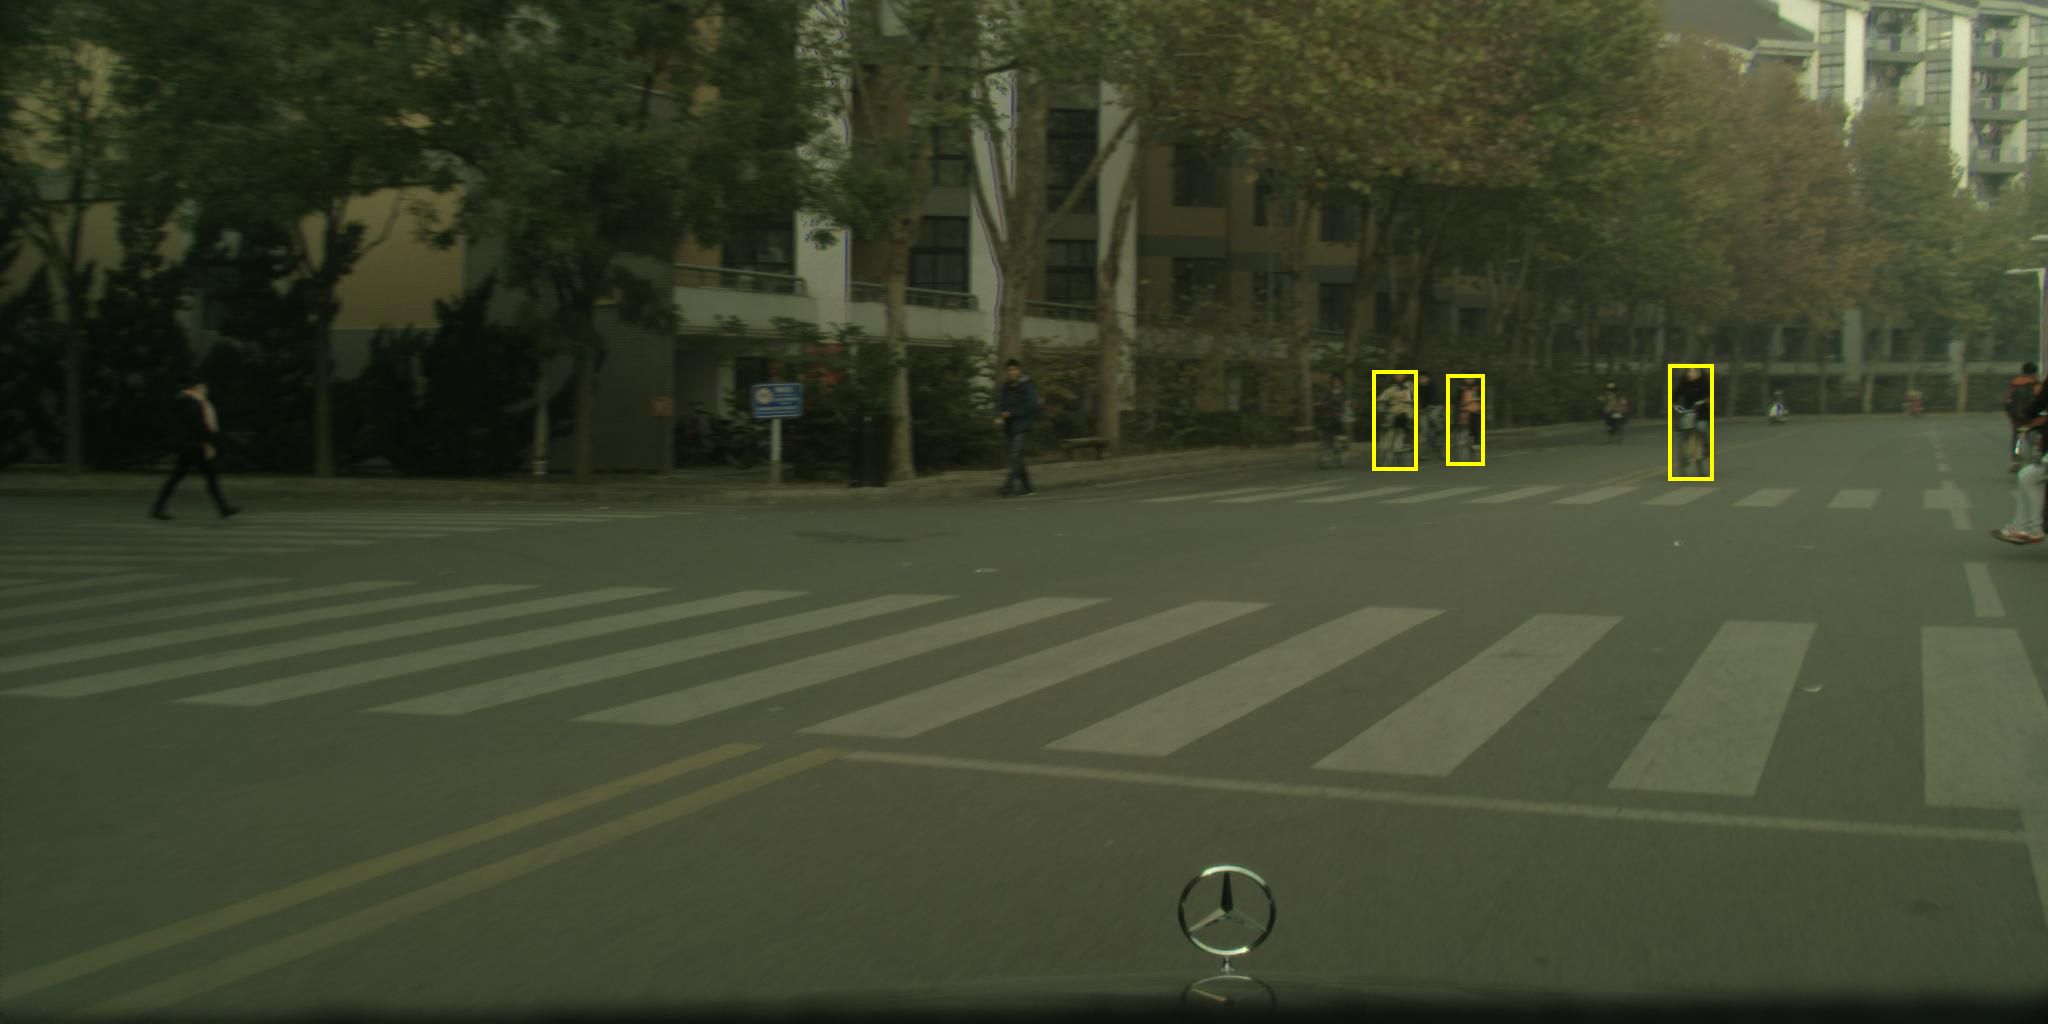

In [84]:
Display_yolo(train[401],colour='yellow')

In [45]:
next(iter(train_iter))[0].type(torch.float32)

tensor([[[[252., 252., 252.,  ...,  65.,  67.,  68.],
          [252., 252., 252.,  ...,  53.,  54.,  55.],
          [252., 252., 252.,  ...,  42.,  43.,  44.],
          ...,
          [ 51.,  53.,  56.,  ...,  29.,  29.,  29.],
          [ 59.,  60.,  61.,  ...,  29.,  29.,  29.],
          [ 61.,  62.,  63.,  ...,  29.,  29.,  29.]],

         [[254., 254., 254.,  ...,  77.,  79.,  80.],
          [254., 254., 254.,  ...,  65.,  66.,  67.],
          [254., 254., 254.,  ...,  54.,  55.,  56.],
          ...,
          [ 62.,  64.,  67.,  ...,  35.,  35.,  35.],
          [ 70.,  71.,  72.,  ...,  35.,  35.,  35.],
          [ 72.,  73.,  74.,  ...,  35.,  35.,  35.]],

         [[253., 253., 253.,  ...,  67.,  69.,  70.],
          [253., 253., 253.,  ...,  55.,  56.,  57.],
          [253., 253., 253.,  ...,  44.,  45.,  46.],
          ...,
          [ 46.,  48.,  51.,  ...,  31.,  31.,  31.],
          [ 54.,  55.,  56.,  ...,  31.,  31.,  31.],
          [ 56.,  57.,  58.,  ...

In [116]:
#Calculating IoU
def Intersection_Over_Union(anchor,bounding_box):
    b1 = Yolo_to_xy(anchor)
    b2 = yolo_to_xy(bounding_box)[1:5]

    xl = torch.maximum(b1[0],b2[0])
    yl = torch.minimum(b1[1],b2[1])
    xr = torch.minimum(b1[2],b2[2])
    yr = torch.maximum(b1[3],b2[3])

    intersection = torch.maximum(torch.tensor([0]),xr-xl)*torch.maximum(torch.tensor([0]),yl-yr)

    anchor_area = anchor[2]*anchor[3]
    bounding_box_area = bounding_box[2]*bounding_box[3]

    return intersection/(anchor_area+bounding_box_area-intersection)

In [ ]:
##Code from d2l, to re-write for yolo

In [ ]:
#Generating priors
def multibox_prior(data, sizes, ratios):
    """Generate anchor boxes with different shapes centered on each pixel."""
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)
    # Offsets are required to move the anchor to the center of a pixel. Since
    # a pixel has height=1 and width=1, we choose to offset our centers by 0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height  # Scaled steps in y axis
    steps_w = 1.0 / in_width  # Scaled steps in x axis
    # Generate all center points for the anchor boxes
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w)
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)
    # Generate `boxes_per_pixel` number of heights and widths that are later
    # used to create anchor box corner coordinates (xmin, xmax, ymin, ymax)
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                   * in_height / in_width  # Handle rectangular inputs
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))
    # Divide by 2 to get half height and half width
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(
        in_height * in_width, 1) / 2
    # Each center point will have `boxes_per_pixel` number of anchor boxes, so
    # generate a grid of all anchor box centers with `boxes_per_pixel` repeats
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                           dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

In [110]:
#Functions for SSD
def cls_predictor(num_inputs,priors,classes):
    return nn.Conv2d(num_inputs,priors*(classes+1),kernel_size=3,padding=1)

def offset_predictor(num_inputs,priors):
    return nn.Conv2d(num_inputs,priors*4,kernel_size=3,padding=1)

def flatten_pred(pred):
    return torch.flatten(pred.permute(0,2,3,1),start_dim=1)

def concat_pred(pred):
    return torch.cat([flatten_pred(p) for p in pred], dim=1)

In [111]:
#Building blocks of SSD
def SSD_Conv_Block(num_inputs,num_outputs,convolutions=2,downsample=2):
    blk = []
    for _ in range(convolutions):
        blk.append(nn.Conv2d(num_inputs,num_outputs,kernel_size=3,padding=1))
        blk.append(nn.BatchNorm2d(num_outputs))
        blk.append(nn.ReLU())
        num_inputs = num_outputs
    blk.append(nn.MaxPool2d(downsample))
    return nn.Sequential(*blk)


def SSD_Base_Block(channels):
    if not isinstance(channels,list):
        raise TypeError("channels argument must be list of channels")

    blk = []
    for i in range(len(channels)-1):
        blk.append(SSD_Conv_Block(channels[i],channels[i+1]))
    return nn.Sequential(*blk)

def SSD_Block_Forward(data,blk,sizes,ratios,cls_predictor,offset_predictor):
    Y = blk(data)
    priors = multibox_prior(Y,sizes=sizes,ratios=ratios)
    cls_preds = cls_predictor(Y)
    offset_preds = offset_predictor(Y)
    return Y,priors, cls_preds, offset_preds

In [140]:
class SSD(nn.Module):
    def __init__(self,classes,base_channels,remaining_channels,sizes,ratios,**kwargs):
        super(SSD,self).__init__(**kwargs)

        if not isinstance(base_channels,list):
            raise TypeError("base_channels argument must be list of channels")

        if not isinstance(remaining_channels,list):
            raise TypeError("remaining_channels argument must be list of channels")

        self.remaining_channels = remaining_channels
        self.sizes = sizes
        self.ratios = ratios
        self.priors = len(self.sizes[0]) + len(self.ratios[0]) - 1

        if not len(self.remaining_channels) == self.priors+1:
            raise TypeError(f'The amount of priors {self.priors+1}, does not match amount of layers {len(self.remaining_channels)}')


        self.classes = classes
        self.base_channels = base_channels



        self.blk_0 = SSD_Base_Block(self.base_channels)
        self.cls_0 = cls_predictor(self.base_channels[-1],self.priors,self.classes)
        self.ofs_0 = offset_predictor(self.base_channels[-1],self.priors)


        for i in range(len(self.remaining_channels)):

            if i == len(self.remaining_channels)-2:

                setattr(self,f'blk_{i+1}',nn.AdaptiveMaxPool2d((1,1)))
                setattr(self,f'cls_{i+1}',cls_predictor(self.remaining_channels[i+1],self.priors,self.classes))
                setattr(self,f'ofs_{i+1}',offset_predictor(self.remaining_channels[i+1],self.priors))
                self.pred_layers = i+2

                break


            setattr(self,f'blk_{i+1}',SSD_Conv_Block(self.remaining_channels[i],self.remaining_channels[i+1]))
            setattr(self,f'cls_{i+1}',cls_predictor(self.remaining_channels[i+1],self.priors,self.classes))
            setattr(self,f'ofs_{i+1}',offset_predictor(self.remaining_channels[i+1],self.priors))

    def forward(self,X):
        anchors, cls_preds,ofs_preds = [None]*self.pred_layers, [None]*self.pred_layers,[None]*self.pred_layers

        for i in range(self.pred_layers):
            X, anchors[i],cls_preds[i],ofs_preds[i] = SSD_Block_Forward(X,getattr(self,f'blk_{i}'),self.sizes[i],self.ratios[i],getattr(self,f'cls_{i}'),getattr(self,f'ofs_{i}'))

        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_pred(cls_preds)
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0],-1,self.classes +1)
        ofs_preds = concat_pred(ofs_preds)
        return anchors,cls_preds,ofs_preds


In [141]:
#Temp
temp_sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
temp_ratios = [[1, 2, 0.5]] * 5
temp_net = SSD(1,[3,16,32,64],[64,128,128,128,128],temp_sizes,temp_ratios)

temp_net.__dict__

{'training': True,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': OrderedDict([('blk_0',
               Sequential(
                 (0): Sequential(
                   (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                   (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                   (2): ReLU()
                   (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                   (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                   (5): ReLU()
                   (6): MaxPool2d(kernel_size=2, stride=2, padding=

In [142]:
temp_img, temp_label = next(iter(train_iter))
temp_img, temp_label = temp_img.type(torch.float32),temp_label.type(torch.float32)
output_anchors, output_cls_preds, output_ofs_preds = temp_net(temp_img)

In [143]:
output_anchors.shape

torch.Size([1, 174084, 4])

In [144]:
output_cls_preds.shape

torch.Size([2, 174084, 2])

In [145]:
output_ofs_preds.shape

torch.Size([2, 696336])

In [134]:
temp_label

tensor([[[ 0.0000,  0.5686,  0.4360,  0.0220,  0.1143],
         [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.8496,  0.5210,  0.0762,  0.4697],
         [ 0.0000,  0.3999,  0.4648,  0.0449,  0.1914],
         [ 0.0000,  0.6531,  0.4316,  0.0161,  0.0742],
         [ 0.0000,  0.6392,  0.4282,  0.0137,  0.0771],
         [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-1.0000,  0.0000,  0.0000,  0.0000, 